In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.interpolate import make_interp_spline, BSpline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter


In [3]:
# Tensile bar specifications in mm
totalLength=int(24)
radiusOfCurvature=int(3)
thickness=float(1.9)
width=float(1.7)
gaugeLength = int(10)

area = thickness*width

In [4]:
# Load data
data = pl.read_csv("/Users/kanghao/Code/MS4089/datasets/tensile data/BM/slice 1/bm slice 1.csv", skip_rows=2)
data.columns = ['Time','Force','Stroke','Extension','Strain']


In [5]:
# Calculate engineering stress and engineering strain
data = data.with_columns(
    (pl.col('Force') / area).alias('engStress'),
    (pl.col('Strain').alias('engStrain'))
)

In [6]:
# Calculate true stress and true strain
data = data.with_columns(
    (pl.col('engStress') * (1 + pl.col('engStrain'))).alias('trueStress'),
    ((np.log(1 + pl.col('engStrain'))) * 100).alias('trueStrain')
)


In [7]:
# Calculate ultimate tensile strength (UTS)
def getUTS(engStress):
    return engStress.max()

getUTS(data['engStress'])



740.6114551083592

Linear equation: y = 1.5673e+03x + (1.1156e+01)
Mean squared error: 4.2978e+03
Variance: -6.7813e+06


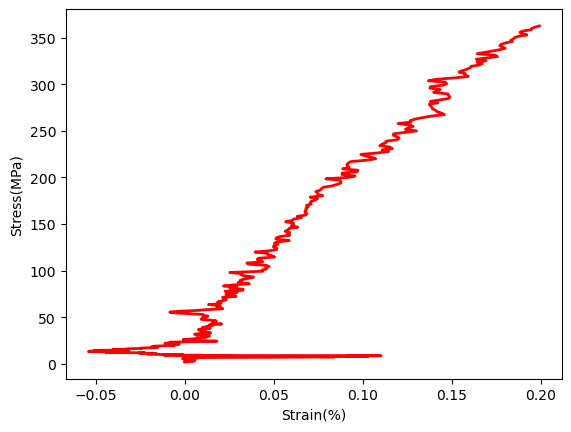

[1567.34182793]


In [11]:
strainPercentage = 0.2 # 0.2% strain
engStressArray = np.array(data['engStress'])
engStrainArray = np.array(data['engStrain'])
end = np.where(engStrainArray > strainPercentage)[0][0]
# Applying linear regression to find the gradient of the elastic region
linearStress = engStressArray[:end]
linearStrain = engStrainArray[:end]

# Split the datapoints to training and testing sets
yTrain = linearStress.reshape(-1,1)
xTrain = linearStrain.reshape(-1,1)

model = linear_model.LinearRegression()
model.fit(xTrain,yTrain)
    
predictions = model.predict(xTrain)
    
 # Print the coefficients
print("Linear equation: y = %.4ex + (%.4e)"%(model.coef_[0], model.intercept_))
print("Mean squared error: %.4e"%(mean_squared_error(yTrain, predictions)))
print("Variance: %.4e"%(r2_score(xTrain, yTrain)))
plt.plot(xTrain, yTrain, color='red', linewidth=2)
plt.xlabel("Strain(%)")
plt.ylabel("Stress(MPa)")
plt.show()

# Calculate elastic modulus
elasticModulus = model.coef_[0]
print(elasticModulus)

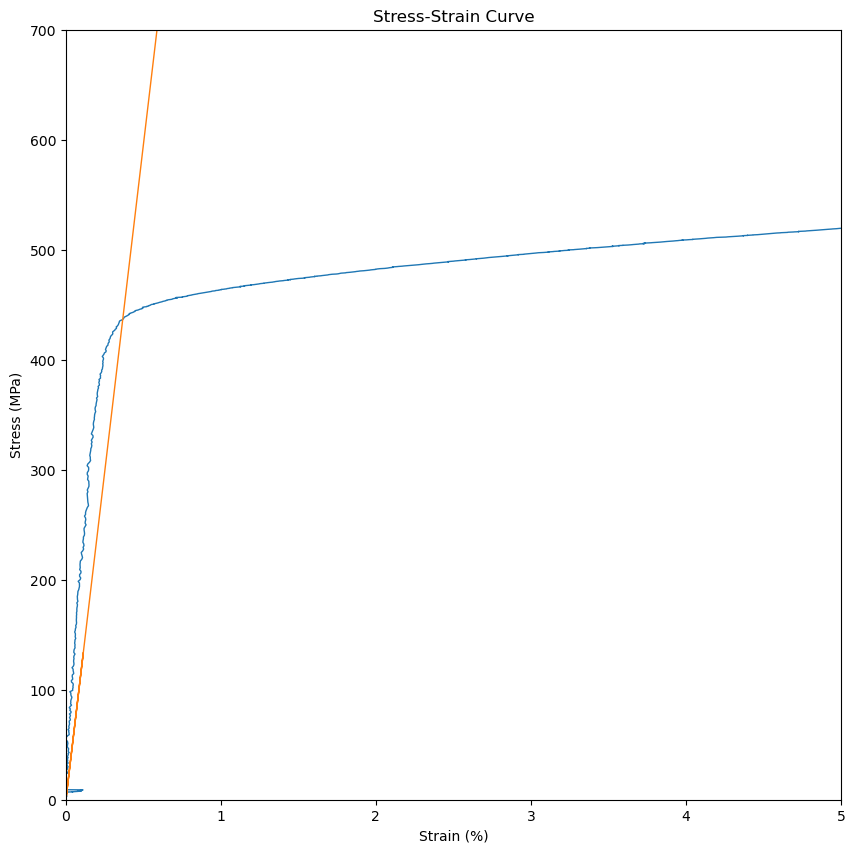

In [57]:
# Plot the stress-strain curve
def plotEngGraph(engStrainArray, engStressArray):
    # Draw a line parallel to the elastic region with an offset of 0.2%
    strainOffset = np.array(engStrainArray + 0.002)
    stressOffset = np.array(elasticModulus*(engStrainArray + 0.002))
    
    
    fig, ax = plt.subplots(figsize=(10,10))

    ax.plot(engStrainArray,engStressArray,strainOffset,stressOffset, linewidth=1)
    ax.set_ylim(0,700)
    ax.set_xlim(0,5)
    ax.set_xlabel('Strain (%)')
    ax.set_ylabel('Stress (MPa)')
    ax.set_title('Stress-Strain Curve')
    plt.show()
    
plotEngGraph(engStrainArray,engStressArray)

In [58]:
strainOffset = np.array(engStrainArray + 0.002)
stressOffset = np.array(elasticModulus*(engStrainArray + 0.002))

# Find the indexes of the yield strength
yieldStrengthIndex = np.argwhere(np.diff(np.sign(stressOffset - engStressArray))).flatten()
yieldStrength = engStressArray[yieldStrengthIndex] # Array of yield strength values due to multiple datapoints
print(f"The yield strength is {round(yieldStrength[-1],1)} MPa")



The yield strength is 436.3 MPa
